In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#create inspector and get datatypes of measurement
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# get datatypes of station
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# find date range for last 12 months
lastest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
lastest_year = int(lastest_date[0][:4])
lastest_month = int(lastest_date[0][5:7])
lastest_day = int(lastest_date[0][-2:])
lastest_date

('2017-08-23')

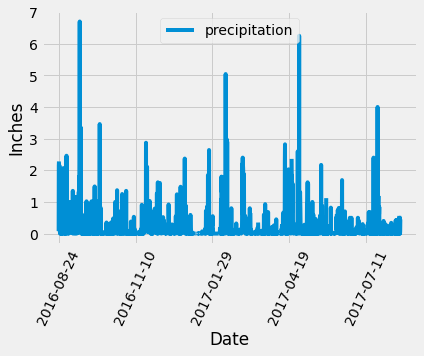

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
oldest_date = dt.date(lastest_year, lastest_month, lastest_day) - dt.timedelta(days=365)
oldest_date
# Perform a query to retrieve the data and precipitation scores
precip_query = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > oldest_date).\
    order_by(measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip_query, columns=['date', 'precipitation'])

# Sort the dataframe by date
df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date',y='precipitation', rot=65)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_query = session.query(station.station, func.count(station.station)).all()
station_query

[('USC00519397', 9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station_query = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_station_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_active_station = session.query(measurement.station).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
max_active_query = session.query(measurement.station, func.min(measurement.tobs),
                                 func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == max_active_station[0]).all()
max_active_df = pd.DataFrame(max_active_query, columns = ['Station', 'MinTemp','MaxTemp','AvgTemp'])
max_active_df

,Station,MinTemp,MaxTemp,AvgTemp
0,USC00519281,54.0,85.0,71.663781


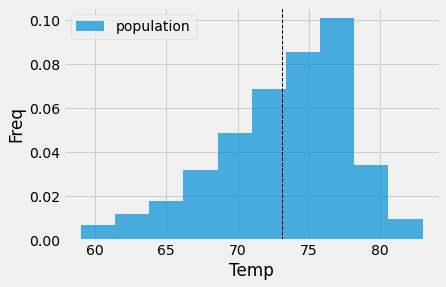

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# find date range for last 12 months for most active station
lastest_date2 = session.query(measurement.date).\
filter(measurement.station == max_active_station[0]).order_by(measurement.date.desc()).first()
lastest_year2 = int(lastest_date[0][:4])
lastest_month2 = int(lastest_date[0][5:7])
lastest_day2 = int(lastest_date[0][-2:])
lastest_date2

# Calculate the date 1 year ago from the last data point for most active station in the database
oldest_date2 = dt.date(lastest_year2, lastest_month2, lastest_day2) - dt.timedelta(days=365)
oldest_date2

# Perform a query to retrieve the data and temp scores
tobs_query = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date > oldest_date2).\
    filter(measurement.station == max_active_station[0]).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_tobs = pd.DataFrame(tobs_query, columns=['date', 'temperature'])

# Sort the dataframe by date
df_tobs.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(df_tobs['temperature'], 10, density=True, alpha=0.7, label="population")
plt.axvline(df_tobs['temperature'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Temp')
plt.ylabel('Freq')
plt.legend()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
